In [37]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_moons
from sklearn.utils import shuffle

In [38]:
n = 10016
batch_size = 32

In [39]:
X, Y = make_moons(n_samples=n, noise=0.1)
X, Y = shuffle(X, Y, random_state=72)

In [40]:
Xs = []
Ys = []
batch_num = int(np.ceil(len(X) / batch_size))

In [41]:
for i in range(batch_num):
    start = i * batch_size
    end = start + batch_size
    Xs.append(X[start:end])
    Ys.append(Y[start:end])

In [42]:
Xs = np.array(Xs).reshape(batch_num, batch_size, 2, 1)
Ys = np.array(Ys).reshape(batch_num, batch_size, 1, 1)
X = X.reshape(n, 2, 1)
Y = Y.reshape(n, 1, 1)

In [43]:
size = [2, 10, 5, 1]

In [44]:
weights = [0]
biases = [0]
for i in range(0, len(size) - 1):
    weights.append(np.random.rand(size[i + 1], size[i]))
    biases.append(np.random.rand(size[i + 1], 1))

In [45]:
weights

[0,
 array([[0.23543192, 0.0907505 ],
        [0.59985041, 0.3746856 ],
        [0.37523629, 0.81557892],
        [0.32340697, 0.19323125],
        [0.88239204, 0.77950794],
        [0.47358803, 0.72488961],
        [0.89902387, 0.14642603],
        [0.51645786, 0.28005278],
        [0.2452862 , 0.74949505],
        [0.52342878, 0.34462067]]),
 array([[0.34750894, 0.82765789, 0.47885232, 0.56495956, 0.7522467 ,
         0.83401644, 0.05549245, 0.71942434, 0.56766732, 0.28665618],
        [0.23232706, 0.01965016, 0.2827596 , 0.74057715, 0.46443267,
         0.92862332, 0.21245027, 0.19058536, 0.74365129, 0.4014949 ],
        [0.14439432, 0.95143555, 0.23891113, 0.89149453, 0.45011508,
         0.80469315, 0.37479321, 0.15713192, 0.75339529, 0.50134132],
        [0.52796736, 0.06266141, 0.82865789, 0.93288694, 0.69551493,
         0.26424401, 0.93345141, 0.68650032, 0.8335013 , 0.29376293],
        [0.42498409, 0.21966964, 0.77017451, 0.4591174 , 0.99285364,
         0.08577411, 0.337362

In [46]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [47]:
def L(y_hat, y):
    return 0.5 * (y_hat - y) ** 2

In [48]:
def feed_forward(xi, weights, biases):
    activations = [xi]
    z1 = weights[1] @ xi + biases[1]
    a1 = sigmoid(z1)
    activations.append(a1)
    for i in range(2, len(weights)):
        zn = weights[i] @ activations[-1] + biases[i]
        an = sigmoid(zn)
        activations.append(an)
    return activations

In [49]:
def sigmoid_derivative(y):
    return y * ( 1 - y )

In [50]:
def backprop(weights, biases, xi, y, activations):
    deltas = [0] * len(activations)
    dL_dwK = [0] * len(activations)
    dL_dbK = [0] * len(activations)

    deltas[-1] = ( activations[-1] - y ) * sigmoid_derivative(activations[-1])
    dL_dwK[-1] = deltas[-1] @ activations[-1].T
    dL_dbK[-1] = deltas[-1]

    for i in range(len(deltas)-2, 0, -1):
        deltas[i] = ( weights[i+1].T @ deltas[ i + 1 ] ) * sigmoid_derivative(activations[i])
        dL_dwK[i] = deltas[i] @ activations[ i - 1 ].T
        dL_dbK[i] = deltas[i]

    return dL_dwK, dL_dbK

In [51]:
act = feed_forward(Xs[0][2], weights, biases)
print(act)
bc = backprop(weights, biases, Xs[0][2], Ys[0][2], act)[0]
for w in bc:
    if type(w) is not int: print(w.shape)

[array([[1.79443093e+00],
       [2.56743409e-04]]), array([[0.74441489],
       [0.81242069],
       [0.77690855],
       [0.72599217],
       [0.91418219],
       [0.85822581],
       [0.83797493],
       [0.78629086],
       [0.70172881],
       [0.80091035]]), array([[0.99034566],
       [0.97967891],
       [0.99360445],
       [0.99677792],
       [0.97767298]]), array([[0.85209352]])]
(10, 2)
(5, 10)
(1, 1)


In [52]:
epochs = 20
lr = 0.1
loss = []
pm, pv = 0, 0

In [53]:
def adam(weight_bias_derivative, weight, learning_rate, previous_moment, previous_velocity, beta_1=0.9, beta_2=0.99, elipson=10**-8):
    gt = weight_bias_derivative
    mt = beta_1 * previous_moment + (1 - beta_1) * gt
    vt = beta_2 * previous_velocity + (1 - beta_2) * gt ** 2
    mt_hat = mt/(1 - beta_1)
    vt_hat = vt/(1 - beta_2)
    ret = weight - (learning_rate*mt_hat)/(np.sqrt(vt_hat)+elipson)
    return ret, previous_moment, previous_velocity

In [55]:
for i in tqdm(range(epochs)):
    epochloss = 0
    for j in range(batch_num):
        for i, xi in enumerate(Xs[j]):
            activations = feed_forward(xi, weights, biases)
            epochloss += L(activations[-1], Ys[j,i])

            dL_dw, dL_db = backprop(weights, biases, xi, Ys[j,i], activations)

            for i, w in enumerate(weights):
                #w -= lr * dL_dw[i]
                w, pm, pv = adam(dL_dw[i], w, lr, pm, pv)
            for i, b in enumerate(biases):
                b -= lr * dL_db[i]

    loss.append(epochloss / n)

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


In [56]:
weights

[0,
 array([[ 0.30600367, -0.9482096 ],
        [ 0.44392259,  0.81117334],
        [ 0.25445359,  1.11402017],
        [-0.35072849,  1.52031672],
        [ 0.95676409,  0.41034747],
        [-0.506812  ,  2.89574894],
        [ 0.46361538, -2.36697893],
        [ 0.35020431, -0.7120273 ],
        [-0.45671079,  2.35779593],
        [ 0.42243494,  0.33632918]]),
 array([[-0.96569262, -0.71303016, -0.40206978, -0.06505867, -0.58027594,
          0.26885672, -1.60068987, -0.57722962,  0.30088987, -1.07217712],
        [-0.94056177, -1.42906415, -0.5142064 ,  0.00353937, -0.78895706,
          0.25189606, -1.42458403, -1.01817935,  0.53632612, -0.84028802],
        [ 0.34813836,  1.04947612,  0.27616979,  0.77752012,  0.60767236,
          0.611797  ,  0.6251372 ,  0.33655338,  0.61592388,  0.63944179],
        [ 1.05856067, -0.31439998, -0.4170735 , -0.80739741,  0.37911105,
         -2.34518761,  2.68427259,  1.05390769, -1.71571158,  0.09578248],
        [ 0.86097901, -0.35369612, -0.

In [57]:
xcoord = np.array([n for n in range(epochs)]).reshape(epochs, 1)
ycoord = np.array(loss).reshape(epochs, 1)
plt.plot(xcoord, ycoord)
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('loss1.png')

ValueError: cannot reshape array of size 28 into shape (20,1)

In [ ]:
def evaluate_visually(x, w, b):
    rb = []
    for xi in x:
        predictions = feed_forward(xi, w, b)
        if predictions[-1] <= 0.5: rb.append('red')
        else: rb.append('blue')
    return rb

In [ ]:
rb = evaluate_visually(X.reshape(n, 2, 1), weights, biases)

In [ ]:
plt.scatter(Xs[:,:,0,:], Xs[:,:,1,:], c=rb)
plt.savefig('prediction1.png')

In [24]:
def evaluate_errors(x, w, b, y):
    rb = []
    for i, xi in enumerate(x):
        p = 0
        predictions = feed_forward(xi, w, b)
        if predictions[-1] <= 0.5: p = 0
        else: p = 1
        if p == Y[i, 0]:
            rb.append('gray')
        else: rb.append('red')
    return rb

In [25]:
br = evaluate_errors(X, weights, biases, Y)

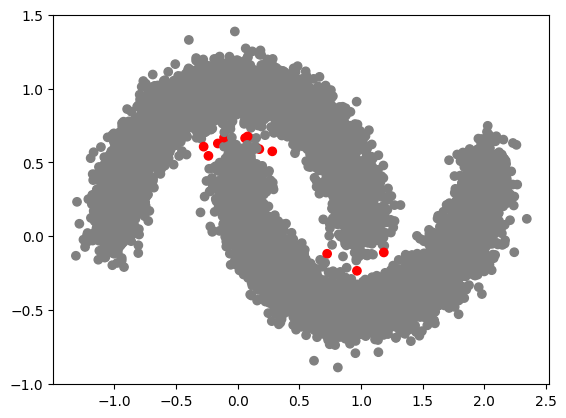

In [26]:
plt.scatter(X[:,0,:], X[:,1,:], c=br)

In [27]:
inc = 0
for c in br:
    if c == 'red': inc += 1
print(f'Training Accuracy {inc} / {n} : {((n-inc)/n)*100:.2f}%')

Training Accuracy 11 / 10016 : 99.89%
